In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))



df = pd.read_csv(os.path.join(os.getcwd(), "../../data/total_4am.csv"), index_col=0)


In [2]:
import pandas as pd
from performance import get_performance, draw_graph

def various_ma(interval_list, df):

    original_df = df.copy()  # Make a copy of the original DataFrame

    for interval in interval_list:
        df = original_df.copy()  # Create a fresh copy for each interval

        df[f"{interval}_ma"] = df['close'].rolling(window=interval).mean()

        # Implement RSI strategy for long positions only
        df['signal'] = 0  # Default to no position
        for i in range(200, len(df)):
            # Buy condition
            if df['close'].iloc[i] >= df[f'{interval}_ma'].iloc[i] and df['close'].iloc[i-1] < df[f'{interval}_ma'].iloc[i-1]:
                df.loc[i, 'signal'] = 1
            # Sell condition
            elif df['close'].iloc[i] < df[f'{interval}_ma'].iloc[i]:
                df.loc[i, 'signal'] = -1

        # Manage positions with stop loss, take profit, and sell signal
        df['position'] = 0
        df['entry_price'] = np.nan
        df['exit_price'] = np.nan
        holding_position = False

        for i in range(1, len(df)):
            if df['signal'].iloc[i] == 1 and not holding_position:
                # Enter position
                df.loc[i, 'position'] = 1
                df.loc[i, 'entry_price'] = df.loc[i, 'close']
                holding_position = True
            elif holding_position:
                # Calculate percentage change since entry
                entry_price = df['entry_price'].iloc[i-1]
                current_price = df['close'].iloc[i]
                percent_change = (current_price - entry_price) / entry_price * 100

                if df['signal'].iloc[i] == -1:  # Sell signal condition
                    # print(f"cond1 on{i}")
                    df.loc[i, 'position'] = 0
                    df.loc[i, 'exit_price'] = current_price
                    holding_position = False
                elif percent_change <= -5:  # Stop loss condition
                    # print(f"cond2 on{i}")
                    df.loc[i, 'position'] = 0
                    df.loc[i, 'exit_price'] = current_price
                    holding_position = False
                # elif percent_change >= 30:  # Take profit condition
                #     print(f"cond3 on{i}")
                #     df['position'].iloc[i] = 0
                #     df['exit_price'].iloc[i] = current_price
                #     holding_position = False
                else:
                    # Continue holding the position if no sell conditions are met
                    # df['position'].iloc[i] = df['position'].iloc[i-1]
                    df.loc[i, 'position'] = df.loc[i-1, 'position']
                    # df['entry_price'].iloc[i] = df['entry_price'].iloc[i-1]
                    df.loc[i, 'entry_price'] = df.loc[i-1, 'entry_price']
            else:
                # No signal and no position
                # df['position'].iloc[i] = df['position'].iloc[i-1]
                df.loc[i, 'position'] = df.loc[i-1, 'position']

        # Calculate the strategy returns (only when in a long position)
        df['strategy_returns'] = df['position'].shift(1) * df['close'].pct_change()

        # Calculate the cumulative returns
        df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

        # Calculate the benchmark cumulative returns (buy and hold strategy)
        df['benchmark_returns'] = (1 + df['close'].pct_change()).cumprod()

        # Save the results to a CSV file
        df.to_csv(f"../../results/ma/ma{(interval)}_cut.csv")

        # Get performance metrics and plot the results
        get_performance(df=df, title=f"ma_{interval}_cut")
        draw_graph(df=df)

        
    df = original_df.copy()  # Create a fresh copy for each interval


======Investment Summary======
Strategy        : ma_5_cut
total_return    : 143.93
cagr            : 37.2
mdd             : 44.87
investing_days  : 1029


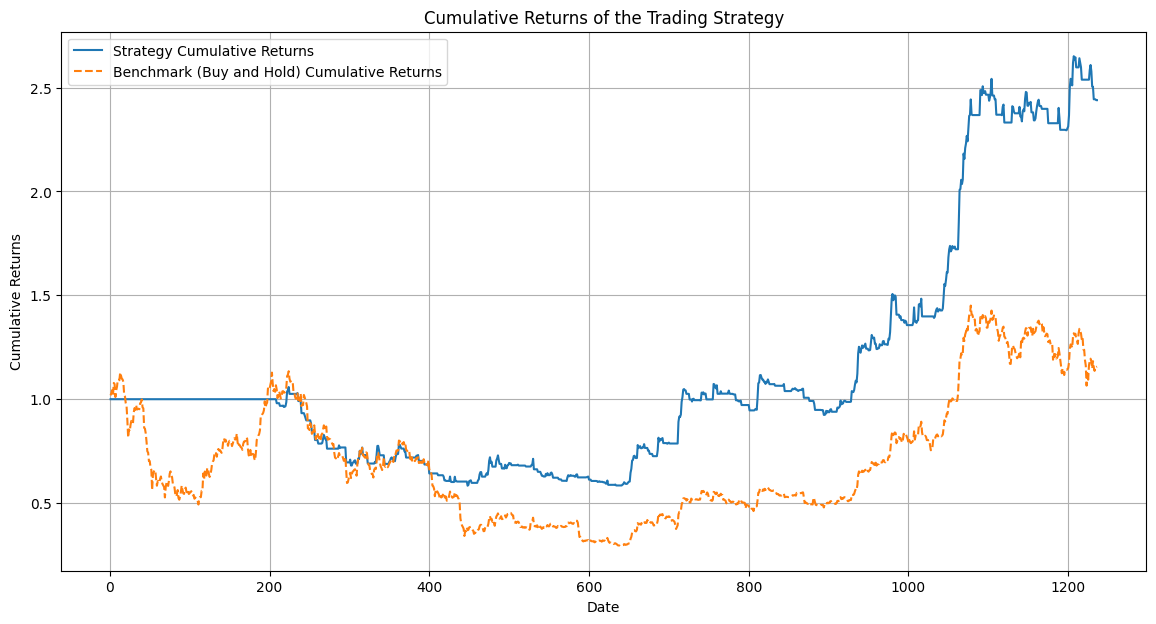

======Investment Summary======
Strategy        : ma_10_cut
total_return    : 88.58
cagr            : 25.24
mdd             : 37.57
investing_days  : 1029


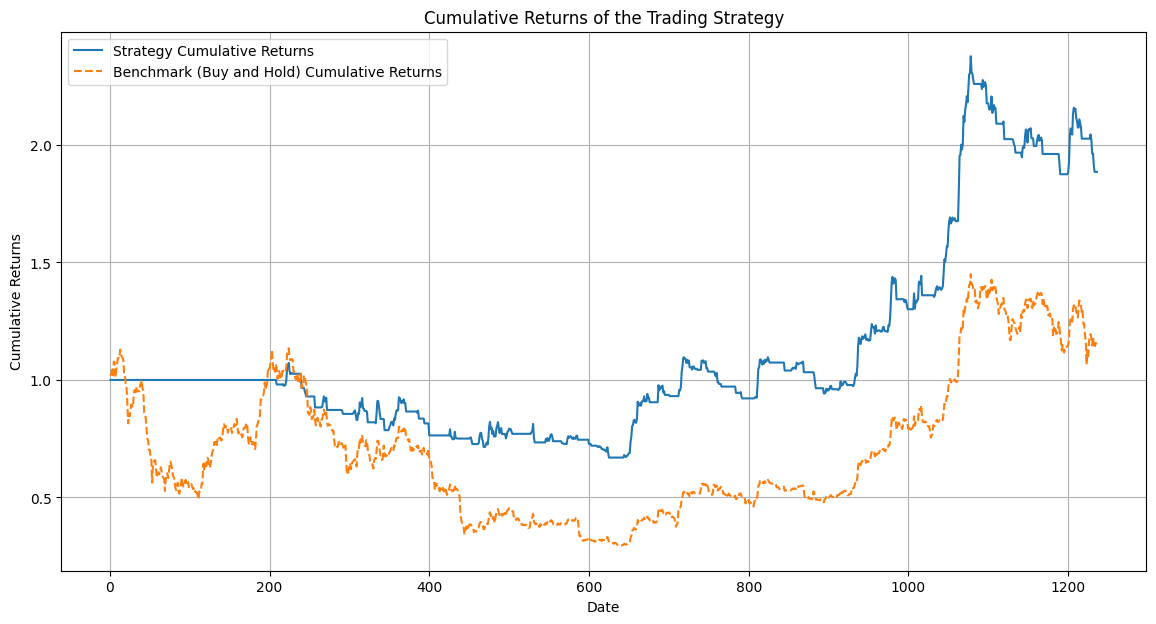

======Investment Summary======
Strategy        : ma_20_cut
total_return    : 114.78
cagr            : 31.29
mdd             : 40.04
investing_days  : 1025


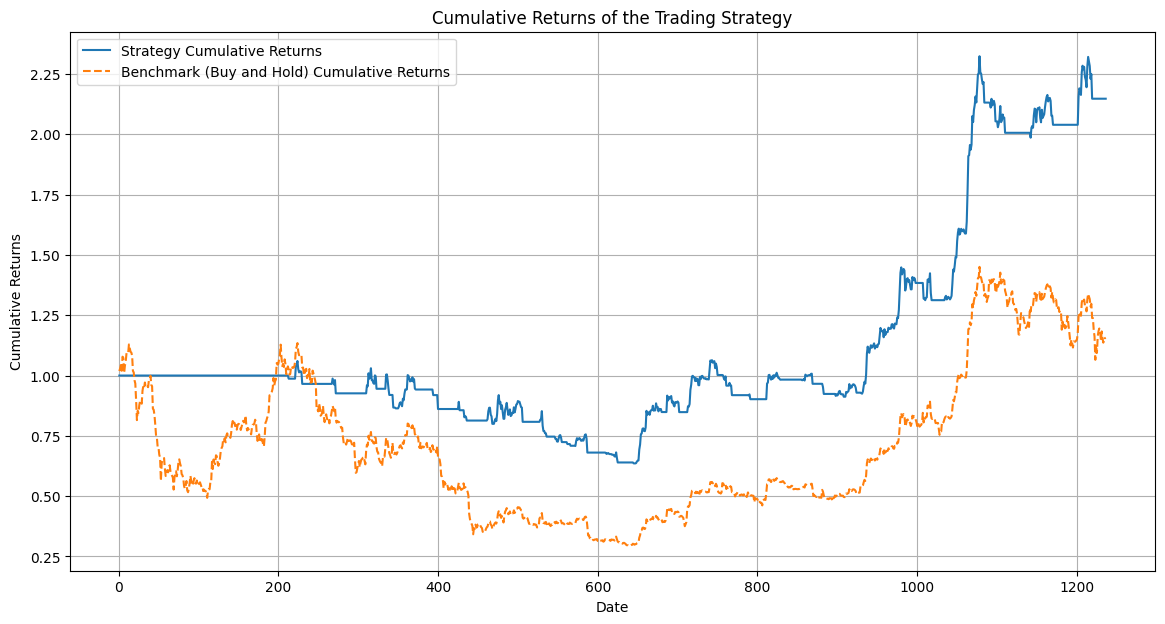

======Investment Summary======
Strategy        : ma_50_cut
total_return    : 118.84
cagr            : 32.98
mdd             : 34.89
investing_days  : 1003


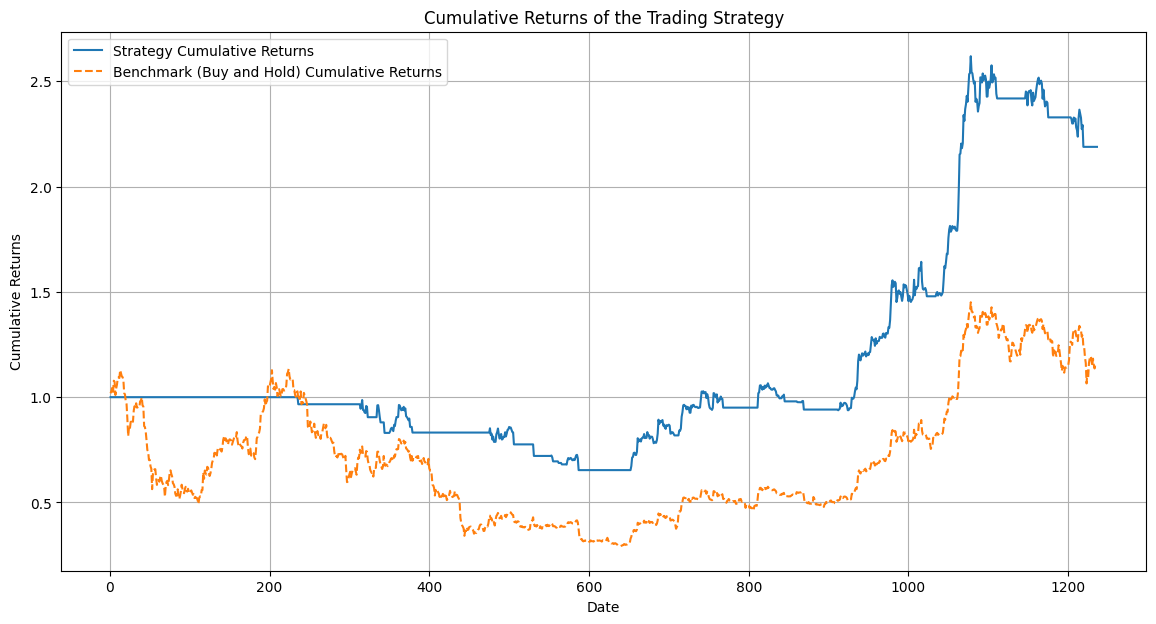

======Investment Summary======
Strategy        : ma_90_cut
total_return    : 90.56
cagr            : 30.62
mdd             : 33.59
investing_days  : 881


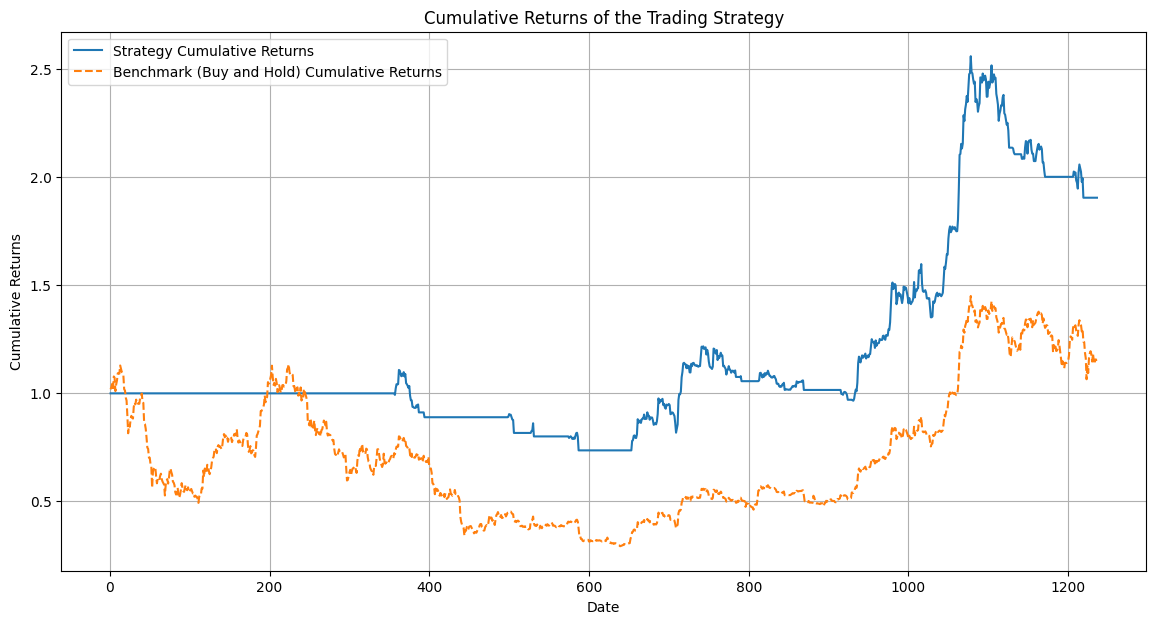

======Investment Summary======
Strategy        : ma_120_cut
total_return    : 103.38
cagr            : 34.33
mdd             : 28.58
investing_days  : 878


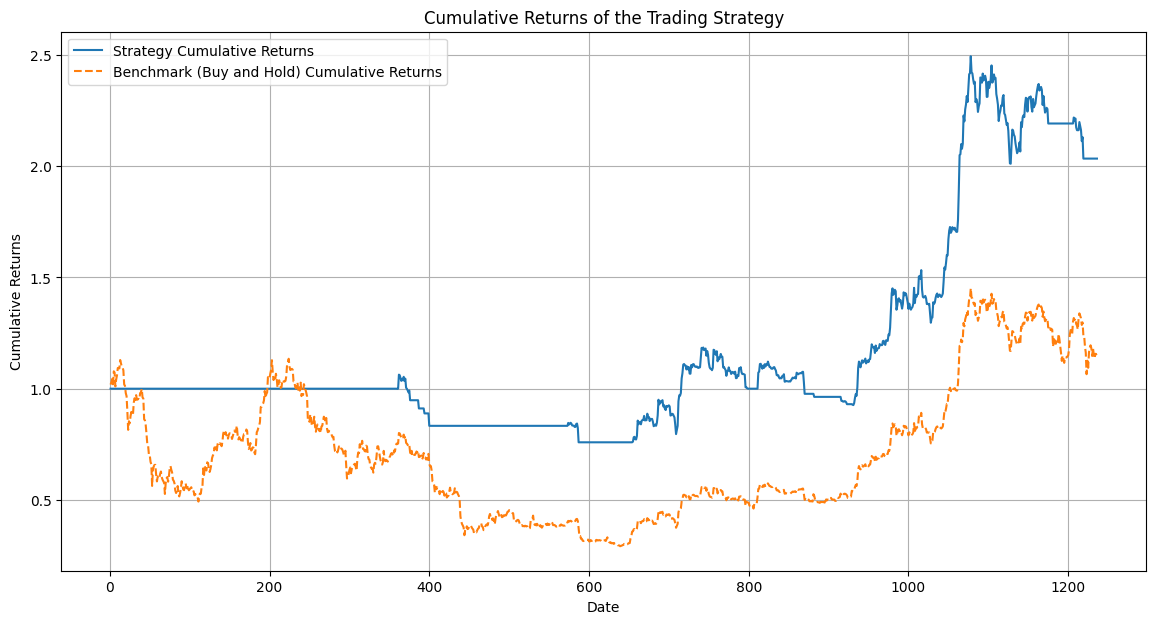

======Investment Summary======
Strategy        : ma_200_cut
total_return    : 162.81
cagr            : 84.27
mdd             : 22.45
investing_days  : 577


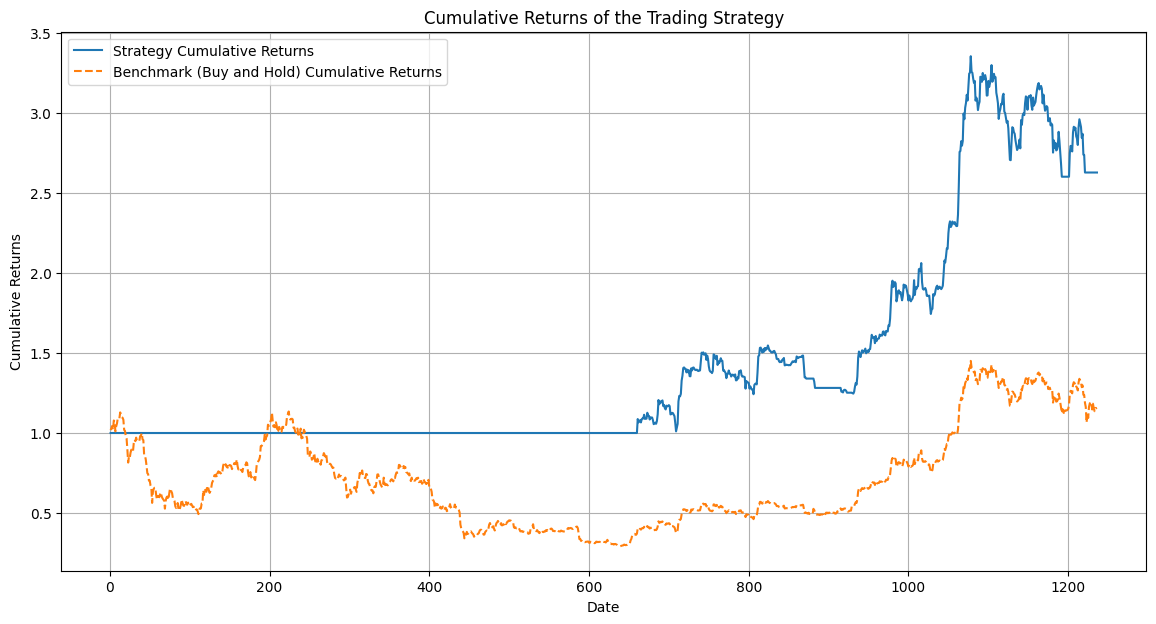

In [3]:
interval_list = [5, 10, 20, 50, 90, 120, 200]
various_ma(interval_list=interval_list, df=df)